In [15]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import os
import numpy as np

### Define paths

In [2]:
base_dir   = 'CellData/chest_xray'

train_dir  = f'{base_dir}/train'
val_dir    = f'{base_dir}/test'

epochs     = 20
batch_size = 64
img_height, img_width = 224,224

### Data Preparation

In [3]:
# Image data generators
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Model Preparation

In [4]:
# Load the ResNet50 model pre-trained on ImageNet
resnet = ResNet50(weights='imagenet', include_top= False, input_shape=(224, 224, 3))

# Freeze all layers except the last 4 layers
for layer in resnet.layers[:-4]:
    layer.trainable = False

In [5]:
# Iterate through the layers of the model
for layer in resnet.layers[-4:]:
    print(f'Layer Name: {layer.name} - Trainable: {layer.trainable}')

Layer Name: conv5_block3_3_conv - Trainable: True
Layer Name: conv5_block3_3_bn - Trainable: True
Layer Name: conv5_block3_add - Trainable: True
Layer Name: conv5_block3_out - Trainable: True


In [6]:
# Create the model
model = Sequential()

# Add the ResNet convolutional base model
model.add(resnet)
 
# Add new layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,333,318 (192.01 MB)

 Trainable params: 13,900,162 (53.02 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

 Optimizer params: 13,900,164 (53.02 MB)

### Model Training

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [8]:
model_ckpt_cb = EarlyStopping(monitor = 'val_accuracy', patience=10, restore_best_weights=True)
early_stop_cb = ModelCheckpoint(filepath = "xray_classification_model.keras", monitor = 'val_accuracy', save_best_only = True, mode ='max')

history = model.fit(train_generator,
                    validation_data = val_generator,
                    callbacks = [model_ckpt_cb, early_stop_cb],
                    epochs = epochs)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 457s 5s/step - accuracy: 0.6984 - loss: 0.6439 - val_accuracy: 0.6250 - val_loss: 0.7448
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 447s 5s/step - accuracy: 0.7610 - loss: 0.4846 - val_accuracy: 0.6250 - val_loss: 0.7499
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 499s 6s/step - accuracy: 0.7887 - loss: 0.4467 - val_accuracy: 0.6250 - val_loss: 0.6934
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 501s 6s/step - accuracy: 0.7887 - loss: 0.4238 - val_accuracy: 0.6554 - val_loss: 0.5430
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 523s 6s/step - accuracy: 0.8158 - loss: 0.4017 - val_accuracy: 0.7420 - val_loss: 0.4889
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 515s 6s/step - accuracy: 0.8224 - loss: 0.3839 - val_accuracy: 0.7340 - val_loss: 0.5110
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2246s 28s/step - accuracy: 0.8281 - loss: 0.3791 - val_accuracy: 0.7324 - val_loss: 0.5332
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 32430s 400s/step - accuracy: 0.8478 - loss: 0.3475 - val_accuracy: 0.7532 - val_lo

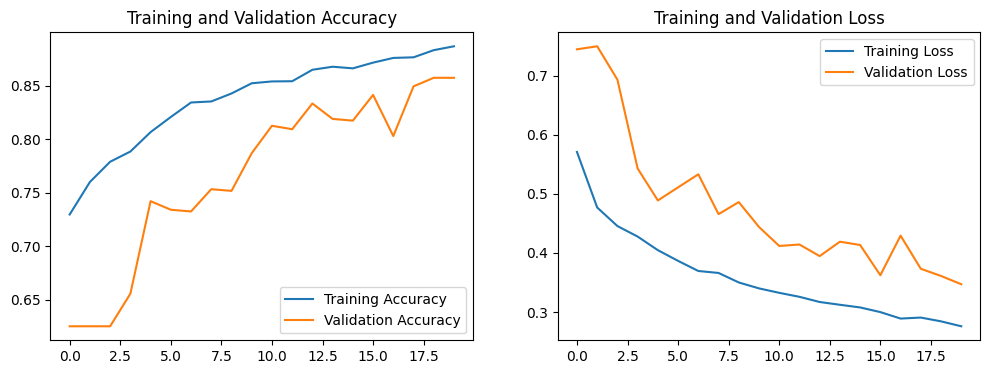

In [9]:
train_acc  = history.history['accuracy']
val_acc    = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
for i in range(3):
    model.evaluate(val_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.8539 - loss: 0.3659
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.8447 - loss: 0.3777
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.8564 - loss: 0.3649
